# **Project 2 CAP 6629**


In this notebook, I explored the application of a Q-network to create an optimal policy for navigating a grid-world maze. The maze includes a start position, goal node, walls, and obstacles. The notebook explores the creation of each component required for the environment, agent, and Q network as well as the resulting loss curve and weight trajectories from training the network.


Grid World Q-Network

---

*Matthew Acs*

## Introduction

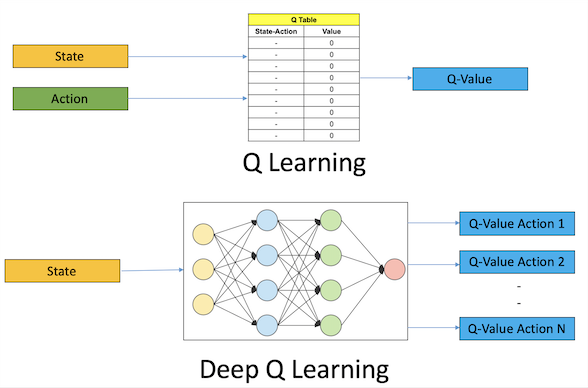

*Q learning uses a Q table while DQL uses a neural network*

### Tabular Q-Learning

In a previous notebook, I found the optimal policy for a 9 by 9 gridworld with portals, obstacles, and a goal node by using tabular Q-learning. The tabular Q-learning method utilizes a n*m table where n is the number of state and m is the number of actions. For the gridworld, this method was very effectively in quickly finding a Q table that converged to the optimal policy. The algorithm showed definitive convergence by 100,000 iterations and worked regardless of the location of the goal node. An exploration of different epsilon values also revealed how a greater focus on exploration increases training time but yields a greater degree of convergence in low yield areas of the Q table. Q-tables are great for scenarios with a small number of state-action pairs, however, once this number becomes large, it becomes infeasible to use a Q-table due to memory limitations. This is the idea behind using a Q-network rather than a Q-table.

### Q-Network

Due to the limitations of tabular Q-learning, this notebook creates a Q-network to solve a similar gridworld problem. Rather than a Q-table, two neural networks, the target and main network, are used to create a simple DQN. The networks contain 2 hidden layers each. The first section of this notebook reviews the theory behind the algorithm as well as the implementation details while the second part of this notebook trains the DQN to find the optimal policy for the grid-world. The training results are shown as well as the model’s convergence and the weight trajectories. Finally, I will compare the practical differences between using a DQN and a Q-table to solve the gridworld problem and draw general conclusions based on the two notebooks.




---

The code below imports the libraries that are necessary for this notebook. Keras and Numpy are the two main data science libraries that I used for this project.



---




In [1]:
## Import necessary python packages
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
from matplotlib import colors
from matplotlib import pyplot as plt

## Environment

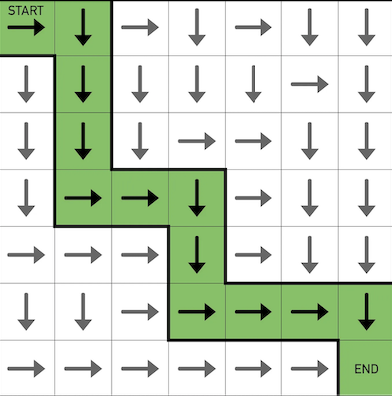

*A general grid-world with an optimal policy*

### Grid-World

The grid-world below is defined as a 4 by 4 world with walls and 3 obstacles in the center of the map. The goal position is at the bottom right of the map while the start position is at the top left. The design of the environment was simplified from the previous notebook due to memory/time restrictions imposed upon Google Golab-hosted Jupyter notebooks. The map is stored in an array in the environment class (as attribute .map).

### States

The states in the environment are the coordinates that the agent is currently located. Because the map is a 4 by 4, there are 13 possible states (16 minus the 3 obstacles) that an agent can be. Furthermore, this dictates that we will have two input nodes to our Q-network later.

### Rewards

Finally, the reward in this grid-world is defined as: 0 for moving to an open space, -10 for hitting a wall or obstacle, and 100 for reaching the goal node. This simple reward system is programmed in the environment's interact method.


---

The code below defines the Environment class. This class is used to represent and interact with the 4x4 grid-world environment. It has an init method that initializes the environment with a default position of the goal (denoted by the number 2) at coordinates (4, 4) and a grid layout consisting of 0s (walls) and 1s (open spaces). The interact method takes an action, x, and y coordinates as input and returns the resulting state, reward, and a flag indicating whether the task is complete based on the agent’s movement in the environment. The display_path method is used to visualize the environment and the agent's path. It uses the matplotlib library to display a grid with different colors for the grid elements (0, 1, and 2), and a red path representing the agent's trajectory.



---



In [2]:
class Environment:

  def __init__(self, x = 4, y = 4):
    self.map = [
    [0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 0],
    [0, 1, 0, 0, 1, 0],
    [0, 1, 0, 1, 1, 0],
    [0, 1, 1, 1, 2, 0],
    [0, 0, 0, 0, 0, 0]
    ]
    self.map[y][x] = 2

  def interact(self, action, x, y):
    x1 = x
    y1 = y

    if action == 0:
      x1 = x + 1
    elif action == 1:
      x1 = x - 1
    elif action == 2:
      y1 = y - 1
    elif action == 3:
      y1 = y + 1

    if self.map[y1][x1] == 0:
      return [x, y], -10, 0
    elif self.map[y1][x1] == 1:
      return [x1, y1], 0, 0
    elif self.map[y1][x1] == 2:
      return [x1, y1], 100, 1

  def display_path(self, path, _x=1, _y=1):
    cmap = colors.ListedColormap(['Black', 'white', 'green'])
    plt.figure(figsize=(6,6))
    plt.pcolor(self.map[::-1],cmap=cmap,edgecolors='k')

    x = [_x+0.5]
    y = [6-(_y+0.5)]
    for i in range(len(path)):
      x.append(path[i][0] + 0.5)
      y.append((5 - path[i][1]) + 0.5)
    plt.plot(x, y, "red")
    plt.axis('off')

    for i in range(4):
      text = str(i+1)

      x_coord = i + 1.5
      y_coord = 5.5
      plt.text(x_coord, y_coord, text, fontsize=12, ha='center', va='center', color='white')

      x_coord = 0.5
      y_coord = 4.5 - i
      plt.text(x_coord, y_coord, text, fontsize=12, ha='center', va='center', color='white')

    plt.show()




---
The code below displays the grid-world map.


---




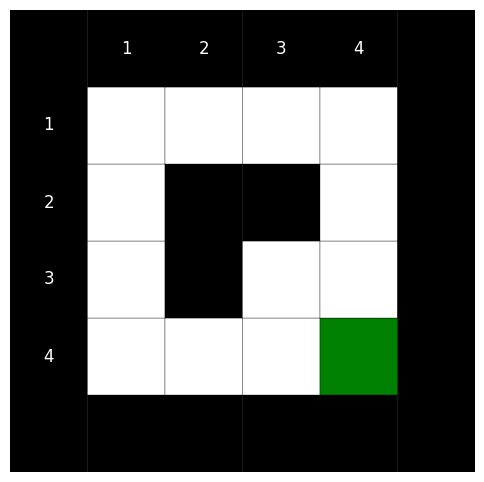

In [3]:
map = Environment()
map.display_path([[1,1]])

*The map above is quite simple: green is the goal, black is a wall/obstacle, and white is an open space. The agent starts in the top left corner.*

## Agent

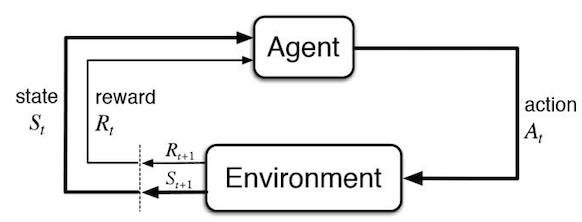

*Agents take actions that modify the state of the environment and provide a reward*

### Actions

The agent can do one of four actions: right, left, down, up. Each action moves the agent 1 space in that direction. If the agent moves into an obstacle or wall, the agent ends up back in the same position. If the agent moves into the goal node, the episode completes and the agent’s position is reset.


---

The code below defines the Agent class. This class represents an agent within the environment. The agent is initialized with default coordinates (1, 1), and it maintains a history of its positions, the number of moves it has made, and its cumulative reward. The move method allows the agent to update its position based on the input coordinates and reward received from its actions. It also records the new position in its history, increments the move count, and updates the cumulative reward. The reset method is used to reset the agent's state, returning it to the initial position, clearing its history, and resetting the move count and cumulative reward. This code defines the core functionality for managing an agent's position and statistics within the environment.



---



In [4]:
class Agent:
  def __init__(self, x=1, y=1):
    self.x = x
    self.y = y
    self.history = []
    self.moves = 0
    self.cumulative_reward = 0

  def move(self, position, reward):
    self.x = position[0]
    self.y = position[1]
    self.history.append(position)
    self.moves = self.moves+1
    self.cumulative_reward = self.cumulative_reward + reward

  def reset(self):
    self.x = 1
    self.y = 1
    self.history = []
    self.moves = 0
    self.cumulative_reward = 0


## Q Network

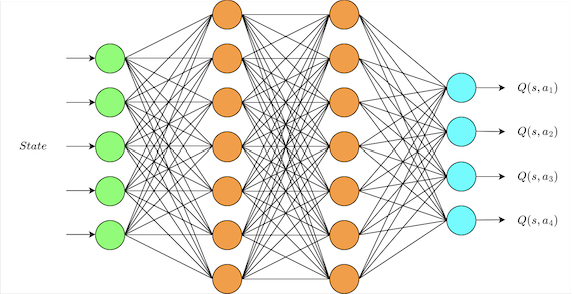

*The neural network in this project used has 2 input nodes, 24 nodes in hidden layer 1, 12 nodes in hidden layer 2, and 4 output nodes*

### Algorithm and Pseudo Code

Essentially, the main difference between a DQN and a tabular Q learning algorithm is that a neural network is used to generate the Q values for each state-action pair given an input state rather than the table. This means that in order to get the next action based on the learned policy, you must pass the current state as input to the neural network and it will return the Q values of the four possible actions. This is called a forward pass, and it predicts the Q-values of based on the state as input. To update the neural network, you must use backpropagation of MSE loss via the target being generated using another forward pass for the next state and the Bellman Equation. To summarize, the forward pass is analogous to looking at the Q-table to get the next action/maximum Q value, the backpropagation is analogous to updating the Q-table using the bellman equation. However, due to the way that neural networks are trained and to make learning more efficient, DQNs use an experience replay as well as a target network. The target network is used to find the Q-values of the next state for use in the Bellman equation. This network is the same as the main network, but the weights are only copied after 100 training cycles. This is used to increase the stability of the networks. The experience replay allows the process to generate a large dataset of tuples (state, action, next state, reward), that the neural network can use to learn. This allows training to occur in large batches and for the network to take advantage of past experiences. An epsilon greedy exploration strategy is also used in DQNs to ensure that the agent has a good balance of exploration and exploitation.

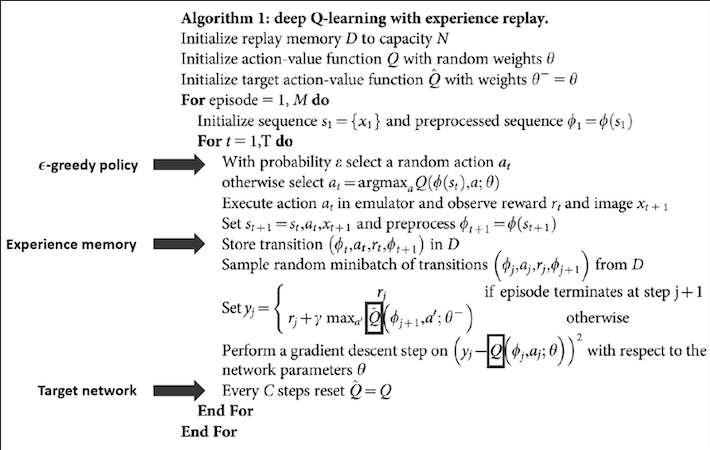

*Pseudo-code for a DQN with experience replay*

The pseudocode shows how the training, experience relay, target network, main network forward pass, and main network backpropagation are implemented and the order that they occur in the algorithm. The implementation that I created below follows a similar algorithm with a few additions such as a decaying epsilon.

### The Importance of a Target Network

The first attempt I had at implementing the DQN did not use a target network, but rather utilized the same network with two forwards passes to get the best action and then the Q values of the next state. This allowed me to backpropagate using only the gradient information from the first forward pass along with the parameters from the Bellman equation. However, upon training the network proved to be very unstable and quickly started propagating NaN values. This instability is because the target is moving as the network is trying to learn the function, creating spiraling model weights. Neural networks need labels that remain stationary for a while to learn.

### Key Design Features

The neural network I used had two hidden layers with 24 and 12 neurons respectively. The input layer accepted 2 features (coordinates) and the output layer had 4 neurons (4 Q values for the possible actions). I used a relu activation for the hidden layers and a linear activation for the output. This is because the problem is a regression problem, so the outputs represent Q values rather than probabilities. I also used Huber loss, which is a smoother derivative of MSE that removes outlies. This is important as the process of DQL can be unstable. The learning rate was set to 0.001 to also help increase stability.


---

The code below defines the NeuralNet function. This function is responsible for creating a neural network model using the TensorFlow and Keras libraries. The model takes two parameters: state_shape and action_shape, which specify the input state space and output action space dimensions, respectively. The neural network architecture consists of three fully connected layers: an input layer with 24 neurons and ReLU activation, a hidden layer with 12 neurons and ReLU activation, and an output layer with as many neurons as there are possible actions (4), using a linear activation function. It initializes the model's weights using the He Uniform initializer and compiles the model using the Huber loss function and the Adam optimizer with a specified learning rate.



---



In [5]:
def NeuralNet(state_shape, action_shape):
    learning_rate = 0.001
    init = tf.keras.initializers.HeUniform(seed = 5)
    model = keras.Sequential()
    model.add(keras.layers.Dense(24, input_shape=(state_shape,), activation='relu', kernel_initializer=init))
    model.add(keras.layers.Dense(12, activation='relu', kernel_initializer=init))
    model.add(keras.layers.Dense(action_shape, activation='linear', kernel_initializer=init))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model


---

The code below defines the train function.  It takes several parameters, including replay_memory (stores past experiences), model (neural network model used for action predictions), target_model (the target neural network model for Q-value estimation), history (a list used to track training history), and flag (indicating whether to update the training history). Within the function, key hyperparameters are defined, such as the learning rate and discount factor. It checks if the size of the replay memory meets a minimum threshold before continuing. If not, it returns early as it requires sufficient experiences to perform meaningful updates. The code then randomly samples a batch of experiences from the replay memory and processes them to update the Q-values for each action. It uses the Bellman equation to calculate the Q-value for each state-action pair. The function can be called with or without the flag, and if the flag is set, it appends the loss from the model training to the provided history list.



---



In [15]:
def train(replay_memory, model, target_model, history, flag):

    ## Setup hyperparameters
    learning_rate = 0.7
    discount_factor = 0.6

    minimum_size = 1000
    if len(replay_memory) < minimum_size:
        return

    X = []
    Y = []
    
    ## Split data into batches and get target predictions
    batch_size = 128
    mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([transition[0] for transition in mini_batch])
    current_qs_list = model.predict(current_states, verbose=0)
    new_current_states = np.array([transition[3] for transition in mini_batch])
    future_qs_list = target_model.predict(new_current_states, verbose=0)

    ## Compute targets using Bellman equation
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q

        X.append(observation)
        Y.append(current_qs)

    ## Train
    if not flag:
      model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)
    elif flag:
      loss = model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)
      history.append(loss.history['loss'])


---

The code below defines the train_q_net function. The function takes several parameters, including the environment (env), an actor (agent), the number of training episodes (train_episodes), and a random seed (seed) for reproducibility. The agent's exploration rate (epsilon) is set to decay from an initial value of 1 to a minimum of 0.01 over time. The code initializes neural network models (model and target_model) to approximate the Q-values and sets their weights. It uses a replay memory (replay_memory) with a maximum length of 50,000 to store past experiences. The code then enters a loop that iterates over training episodes. Within each episode, the agent interacts with the environment, making decisions based on the epsilon-greedy policy. The agent collects experiences and stores them in the replay memory. The code also updates the main network periodically, using the "train" function with a flag (1 or 0) to control whether to update the training history. The history variable is used to track training progress, and weights are recorded for different layers of the neural network. Additionally, the code includes logic for printing cumulative rewards at specific intervals and adjusting the epsilon value as training progresses. It generally follows the pseudo-code described previously.



---



In [16]:
def train_q_net(env, actor, train_episodes, seed):
    
    tf.random.set_seed(seed)
    np.random.seed(seed)

    ## Setup hyperparameters
    epsilon = 1
    max_epsilon = 1
    min_epsilon = 0.01
    decay = 0.01
    
    history = []
    weights = []
    for i in range(384):
      weights.append([])

    model = NeuralNet(2, 4)
    target_model = NeuralNet(2, 4)
    target_model.set_weights(model.get_weights())

    replay_memory = deque(maxlen=50_000)
    target_update_counter = 0
    steps_to_update_target_model = 0

    ## For each episode
    for episode in range(train_episodes):
        
        total_training_rewards = 0
        actor.reset()
        observation = np.array([actor.x, actor.y])
        done = False

        ## Do until goal node is not reached
        while done == False:
            
            steps_to_update_target_model += 1
            random_number = np.random.rand()

            ## Explore
            if random_number <= epsilon:
                rng = np.random.default_rng()
                action = rng.integers(low=0, high=4)

            ## Exploit
            else:
                encoded = observation
                encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
                predicted = model.predict(encoded_reshaped, verbose=0).flatten()
                action = np.argmax(predicted)

            ## Interact with environment
            new_observation, reward, done = env.interact(action, actor.x, actor.y)
            new_observation = np.array(new_observation)
            actor.move(new_observation, reward)

            if actor.moves >= 100:
              epsilon = 1

            ## Add to replay memory
            replay_memory.append([observation, action, reward, new_observation, done])

            ## Train main model every 4 iterations
            if steps_to_update_target_model % 4 == 0 or done:

              if steps_to_update_target_model % 100 == 0 or done:
                train(replay_memory, model, target_model, history, 1)

                k=0
                first_layer_weights = model.layers[0].get_weights()[0]
                for i in range(2):
                  for j in range(24):
                    weights[k].append(first_layer_weights[i][j])
                    k += 1

                second_layer_weights = model.layers[1].get_weights()[0]
                for i in range(24):
                  for j in range(12):
                    weights[k].append(second_layer_weights[i][j])
                    k += 1

                third_layer_weights = model.layers[2].get_weights()[0]
                for i in range(12):
                  for j in range(4):
                    weights[k].append(third_layer_weights[i][j])
                    k += 1

              else:
                train(replay_memory, model, target_model, history, 0)

            observation = new_observation
            total_training_rewards += reward

            ## Epsiode Complete
            if done:
              if episode % 50 == 0:
                print('Cumulative reward is {} after episode {}'.format(total_training_rewards, episode))
                  
              total_training_rewards += 1
                
              ## Copy weights to target network every 100 iterations
              if steps_to_update_target_model >= 100:
                  target_model.set_weights(model.get_weights())
                  steps_to_update_target_model = 0
              break

        ## Decay epsilon
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
        
    return model, history, weights


---

The code below defines the trace function. This function is designed to trace the actions of an agent as it navigates through a maze using a given model. The agent's starting position is specified by the x and y parameters, with default values of 1 for both. Within the loop, the agent selects its actions based on the model's predictions. It encodes its current position, makes predictions, and then converts the predicted action to a human-readable string using the "convert_to_move" function. The agent interacts with the maze, moving according to its selected action, and records its moves and cumulative reward during the process. The loop runs until the "done" variable becomes 1. The function returns a list of actions taken by the agent, the number of moves it made, its cumulative reward, and its history. The "convert_to_move" function is a simple utility to map action integers to human-readable move directions.



---



In [8]:
def trace(model, maze, x=1, y=1):
  bob = Agent(x,y)

  actions = []

  done = 0
  i = 0
  while not done:
    encoded = np.array([bob.x,bob.y])
    encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
    predicted = model.predict(encoded_reshaped, verbose=0).flatten()
    action = np.argmax(predicted)

    actions.append(convert_to_move(action))

    position, reward, done = maze.interact(action, bob.x, bob.y)
    bob.move(position, reward)
    i += 1
    if i == 50:
      done = 1

  return actions, bob.moves, bob.cumulative_reward, bob.history

def convert_to_move(move):

  if move == 0:
    return "right"
  elif move == 1:
    return "left"
  elif move == 2:
    return "up"
  elif move == 3:
    return "down"

## Training and Results

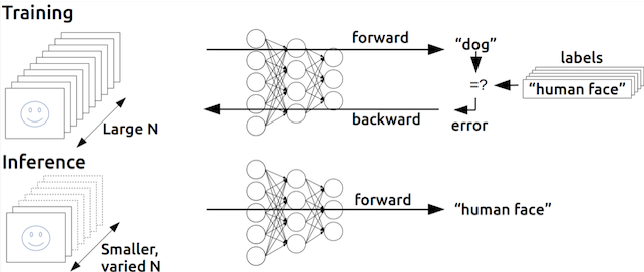

*Neural networks predict using forward passes and train using backward passes*

The next step is to train the DQL model. This process is RAM and time consuming. I trained for 1000 iterations as I found it to be enough to ensure convergence of the optimal policy from the start node. I also saved the model loss history and weights for further analysis.


---

I initiated an environment using the Environment class and created an agent with the Agent class. With the environment and agent ready, I set the parameters for my training process. I decided to run 1000 training episodes and set a random seed value of 5 for reproducibility. Then, I called the train_q_net function, passing in the environment, agent, number of training episodes, and the seed as parameters. The training history and weights of the neural network are stored for further analysis and evaluation. The code below represents the setup and execution of the training process for the agent to learn and improve its decision-making skills in the given environment.



---



In [9]:
env = Environment()
actor = Agent()
train_episodes = 1000
seed = 5

model, history, weights = train_q_net(env, actor, train_episodes, seed)

Cumulative reward is -140 after episode 0
Cumulative reward is -600 after episode 50
Cumulative reward is -510 after episode 100
Cumulative reward is -630 after episode 150
Cumulative reward is -520 after episode 200
Cumulative reward is 70 after episode 250
Cumulative reward is 100 after episode 300
Cumulative reward is 100 after episode 350
Cumulative reward is 90 after episode 400
Cumulative reward is 100 after episode 450
Cumulative reward is 100 after episode 500
Cumulative reward is 100 after episode 550
Cumulative reward is 100 after episode 600
Cumulative reward is 100 after episode 650
Cumulative reward is 100 after episode 700
Cumulative reward is 100 after episode 750
Cumulative reward is 100 after episode 800
Cumulative reward is 100 after episode 850
Cumulative reward is 100 after episode 900
Cumulative reward is 100 after episode 950


### Final Path Based on Learned Policy

To visualize the result, the following section explores the path the agent takes based on the neural network action predictions from the default start position and another start position.


---

The code below displays the agents path based on the learned policy. The agent started at (1,1) in this instance.



---



Agent Path Based on Learned Policy
----------------------------------
Actions: ['right', 'right', 'right', 'down', 'down', 'down']
Steps: 6
Reward: 100
Path: [[2, 1], [3, 1], [4, 1], [4, 2], [4, 3], [4, 4]]



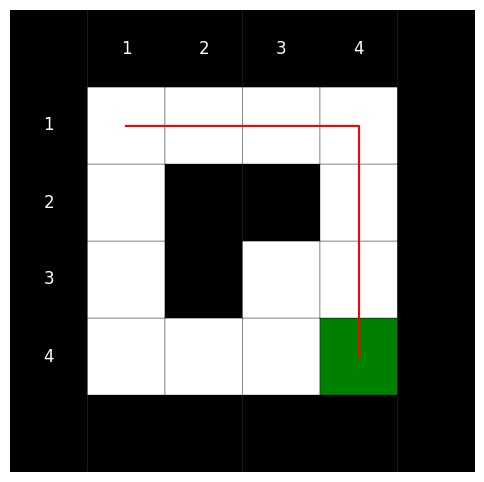

In [10]:
a, s, r, h = trace(model, env)

print("Agent Path Based on Learned Policy")
print("----------------------------------")
print("Actions: " + str(a))
print("Steps: " + str(s))
print("Reward: " + str(r))
print("Path: " + str(h))
print()

env.display_path(h)


---

The code below displays the agent’s path again, however, the agent now starts at (3,3).



---



Agent Path Based on Learned Policy
----------------------------------
Actions: ['right', 'down']
Steps: 2
Reward: 100
Path: [[4, 3], [4, 4]]



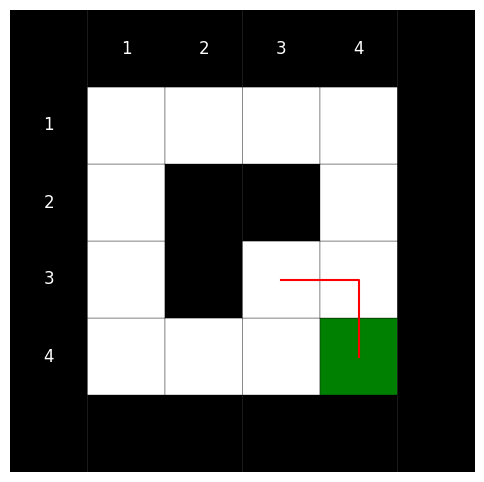

In [11]:
a, s, r, h = trace(model, env, 3, 3)

print("Agent Path Based on Learned Policy")
print("----------------------------------")
print("Actions: " + str(a))
print("Steps: " + str(s))
print("Reward: " + str(r))
print("Path: " + str(h))
print()

env.display_path(h, 3, 3)

### Loss Convergence

To visualize the training process, the loss curve is printed below.


---

The code below plots the loss curve from the training process.


---



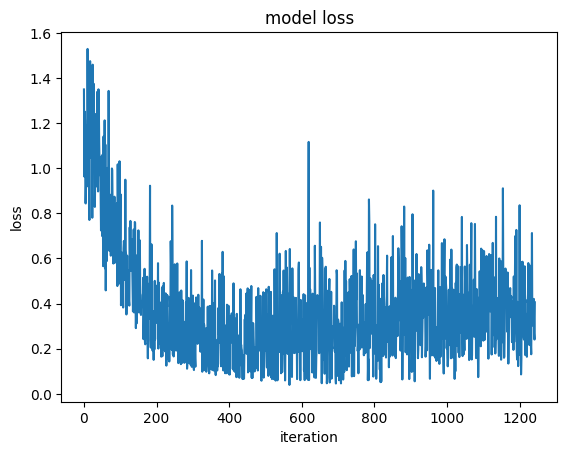

In [12]:
plt.plot(history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.show()

### Weight Trajectories

Finally, the weight trajectories are visualized to see model convergence.


---

The code below plots the weight trajectories from the training process. All 384 weights are shown.



---



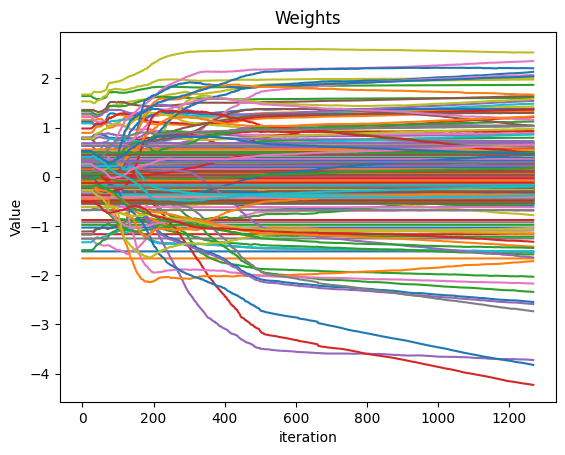

In [13]:
for i in range(384):
  if i % 1 == 0:
    plt.plot(weights[i])

plt.title('Weights')
plt.ylabel('Value')
plt.xlabel('iteration')
plt.show()


---

The code below plots the weight trajectories from the training process. A tenth of the total weights are shown.



---



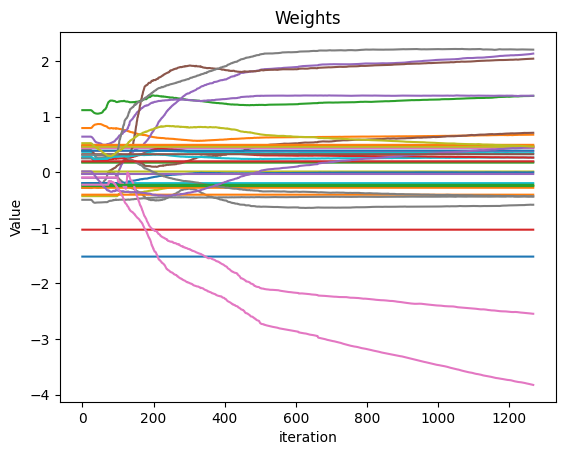

In [14]:
for i in range(384):
  if i % 10 == 0:
    plt.plot(weights[i])

plt.title('Weights')
plt.ylabel('Value')
plt.xlabel('iteration')
plt.show()

## Discussions and Conclusions

### Version 1 Through Version Googol


This assignment took many versions to finally achieve a successful implementation. My first implementation utilized a neural network that I created only using numpy for complete control. However, I quickly realized that this proved to be very easy to create bugs in and difficult to integrate into my original codebase. My next set of versions utilized Keras, however, I forewent the target network and used one neural network. I also did not implement a replay memory and trained on every iteration. This proved very unstable and quickly started to propagate NaN values. Adding a replay memory and training less often increased the stability a little, but not enough to converge to the correct policy. Next, after much research, I arrived at the current implementation using a memory replay and target network. This implementation was also quite finicky at first, but after many hours of experimenting, I found the best hyperparameters and map size. The process from start to finish took me tens of notebooks and many frustrating failed attempts. I often found myself scrapping good versions simply due to the computational challenge of executing the training process. 



### Man Versus RAM



For the duration of the development process of this assignment, I was in a battle against RAM. Google Colab’s RAM limitations were not enough for me to complete the training process on a 5 by 5 grid, forcing me to simplify the grid. I maxed out the servers RAM limitations several times, wasting many hours waiting for nothing. Eventually I got frustrated enough that I downloaded a local version of Jupyter and used my hardware. However, I maxed out my Mac’s 64 GBs of RAM as well. This forced me to simplify the grid to a reasonable size so that the training process could complete. In the future, to decrease this problem I will ensure that I deallocate all unused variables from memory so that each iteration does not waste space unnecessarily. 



### Man Versus Time




Another frustration I had was the time complexity of the training process. Each time I trained the DQN, it took around an hour. An hour to find out that I messed up. This was very frustrating as it was hard to tune the hyperparameters, debug, or modify the code quickly. A better hardware setup or more optimized code may have helped here. 

### It Finally Worked



After a long and frustrating development and learning process, I finally arrived at this notebook. The hyperparameters were tuned to reasonable values for the current situation, the gridworld is sufficiently simple, and the codebase records all necessary values for future data analysis. Recording the weights and losses through the training process also added an increased RAM burden due to the sheer volume of training that occurred. The training process took 1,000 episodes with each episode average around 50-100 network training updates. That is O(1,000,000) total datapoints (>300 weights), a large memory burden. However, at the end, the code executed, I did not run out of RAM, and the loss and weight convergence curves displayed the expected result. 

### Convergence


The path taken by the agent based on the neural networks action predictions clearly shows that the process converged to the optimal policy for the start position. This is because the agent takes the optimal path to the goal node based on the predictions obtained from the trained Q-network. Testing it on a different start location also shows that the agent finds the best path to the goal node, further showing convergence. The loss curve also shows a decrease in loss overtime until it stagnates. This represents convergence of the Q-network to the Q values. However, due to the epsilon strategy used, low-yield areas of the "table" may not have yet converged. The agent is unlikely to visit some spaces due to the starting location of the simulation being 1,1. This means that those spaces may not have entirely converged yet to the correct Q-values. Finally, the weight trajectories also indicate convergence. Initially, the weights were random, and after a few iterations of training they started to move rapidly. By the end of the training process, most weights have converged to a value, indicating model convergence. However, some weights are still moving by the 1,000th episode, indicating that the model may benefit from more iterations of training. Furthermore, some weights did not move through the training process. This also indicates that the network may be more complex than this problem requires. 

### Q-Network vs Tabular Q-Learning

Overall, Q-networks are useful in situations where the number of states is very large. Clearly, the Q-network was able to estimate the Q-values and act as a Q-table estimator. However, it was far more computational expensive and inefficient to use a Q-network in this case when compared to a Q-table. The Q-table from the last assignment took second to train while this Q-network took hours. Furthermore, the memory implications and time complexity limited the complexity of the map that could be used in this assignment. Q-networks are much more useful for complex situations with large state spaces (or continuous ones). A small gridworld such as the one used in this project is far better tackled with a Q-table. For instance, applications that use images as state inputs would benefit greatly from using a Q-network.

### Future improvements and lessons learned

This assignment took a long time to complete due to the sheer computation complexity involved in training a Q-network. Given my limited hardware resources, it was incredibly time consuming to tune hyperparameters and modify my code. In the future, I would also optimize my use of RAM to prevent the exhaustion of all hardware resources during the training process. It is clearly important to deallocate all variables that are no longer used. I also learned that sometimes classical and simpler solutions are better than complex and heavy-duty ones. When I first started learning about machine learning, my go-to was a neural network for any and every classification problem. However, given that a Q-table performed better on this task, I think that problems should be carefully analyzed for the best “tool for the job” rather than diving straight for a neural network. For instance, a classification problem may be better solved with an SVM than a NN.

## References

- https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc
    
Inspiration for DQN network implementation. DQN code snippets and ideas were modified from this DQN implementation for the cartpole environment.
- https://medium.com/@sayalipangre123/hardware-for-machine-learning-and-neural-network-864544e54e4f
- https://towardsdatascience.com/training-an-agent-to-beat-grid-world-fac8a48109a8
- https://becominghuman.ai/train-your-first-rl-agent-a-step-by-step-guide-353bced83722
- https://www.researchgate.net/figure/Agent-environment-interaction-in-RL-framework-3_fig1_331992084
- https://wikidocs.net/174548
